In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

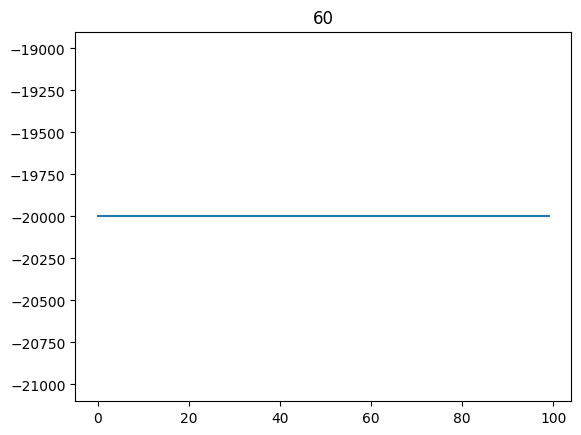

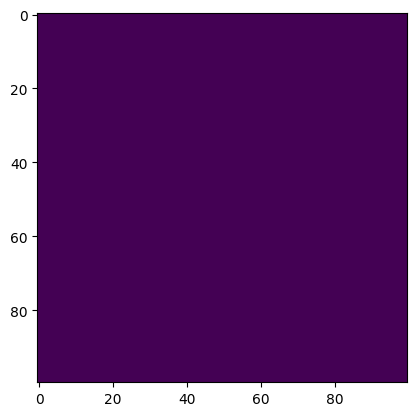

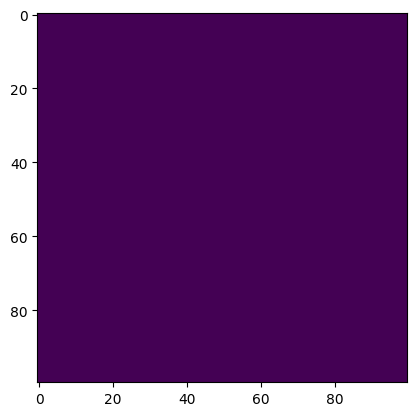

In [86]:
def energy(a,j):
    h = -j * (a * (np.roll(a,1,axis=0) + np.roll(a,1, axis = 1)))
    return np.sum(h)


def randominitial(n):
    b = np.random.choice(2,(n,n))
    b[b==0] = -1
    return b

def probabilities(j,T):

    probs = []
    dE = np.array([-8,-4.,0.,4.,8.])
    dE *= j
    
    if T == 0:
        probs = [1,1,1,0,0]
        return dict(zip(dE,probs))
    
    for de in dE:
        probs.append(min(1,np.exp(-de*(T)**(-1))))
    return dict(zip(dE, probs))



def convergence(steps:int, n,j,T,a_in, fname = 'animation.mp4'):

    probs = probabilities(j,T)
    
    save_every = 1000
    numsteps = steps/save_every

    a = a_in.copy()

    energies = np.empty(steps)

    E = energy(a,j)

    data = []

    for i in range(steps):
        energies[i] = E
        '''
        if i % numsteps == 0:
            data.append(a)
    '''    
        
        x = np.random.randint(0,n)
        y = np.random.randint(0,n)

        b = a.copy()
        b[x,y] *= -1

        dE = -j*(b[x,y] - a[x,y])*(a[x,(y+1)%n] + a[(x+1)%n,y] + a[x,y-1] + a[x-1,y])

        '''if i % 100000 == 0:
            plt.imshow(a)
            plt.title(f"{i}th step")
            plt.show()
        '''
        
        if dE <= 0 or np.random.rand() <= probs[dE]:
            E += dE
            a = b.copy()

    '''    
    fig, ax = plt.subplots()
    im = ax.imshow(data[0])

    def update(frame):
        im.set_array(data[frame])
        return [im]

    ani = anim.FuncAnimation(fig, update, frames=len(data), interval=10, blit=True)

    ani.save(fname, fps=60)

    plt.show()
'''
    return np.arange(steps), energies, a, a_in


n = 100
a_in = randominitial(n)
a_in = np.ones((n,n))
steps = 100
T = 0.2

step, u, a, a_in = convergence(int(steps), n, 1, T, a_in, fname = f'animation_T1.5.mp4')
plt.plot(step, u)
plt.title(str(i))
plt.show()


plt.imshow(a_in)
plt.show()
plt.imshow(a)
plt.show()

In [87]:
print(np.sum(a)); print(np.sum(a_in))

10000.0
10000.0


In [104]:
def energy(a,j, H):
    h = -j * (a * (np.roll(a,1,axis=0) + np.roll(a,1, axis = 1))) - H * a
    return np.sum(h)

def sin_H(n,factor=0.5):
    x = np.arange(n)
    y = np.arange(n)
    return np.sin(factor*x[:, None]) + np.sin(factor * y[None, :])


def circle_H(n,r):
    """
    Create a 2D array with 1s in a circle and 0s elsewhere.
    
    Parameters:
        shape  : (rows, cols) of output array
        center : (y, x) center of the circle
        radius : radius of the circle
    Returns:
        mask : 2D numpy array of 0s and 1s
    """
    Y, X = np.ogrid[:n,:n]
    dist_sq = (Y - n//2)**2 + (X - n//2)**2
    mask = dist_sq <= r**2
    return mask.astype(np.double)

print(circle_H(n,n/4))


def randominitial(n):
    b = np.random.choice(2,(n,n))
    b[b==0] = -1
    return b

def probabilities(j,T):

    probs = []
    dE = np.array([-8,-4.,0.,4.,8.])
    dE *= j
    
    if T == 0:
        probs = [1,1,1,0,0]
        return dict(zip(dE,probs))
    
    for de in dE:
        probs.append(min(1,np.exp(-de*(T)**(-1))))
    return dict(zip(dE, probs))




[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


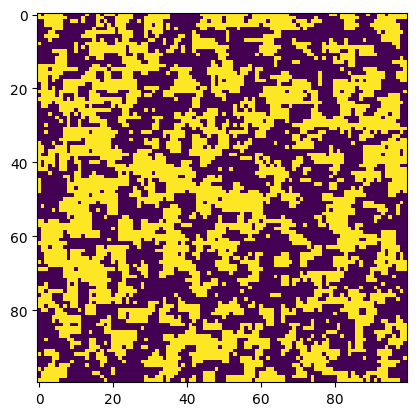

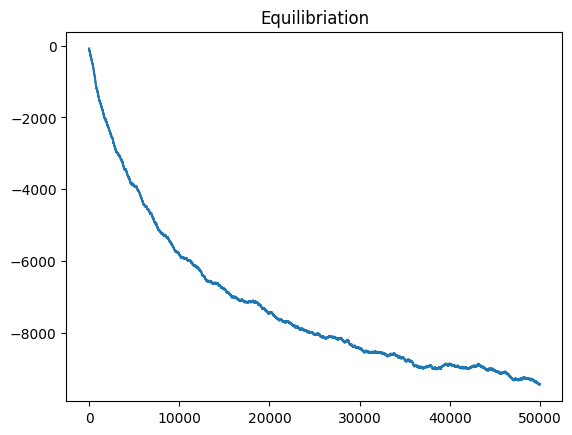

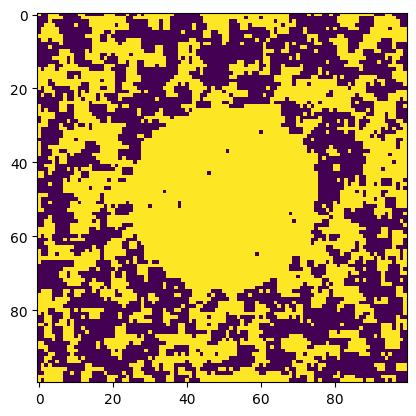

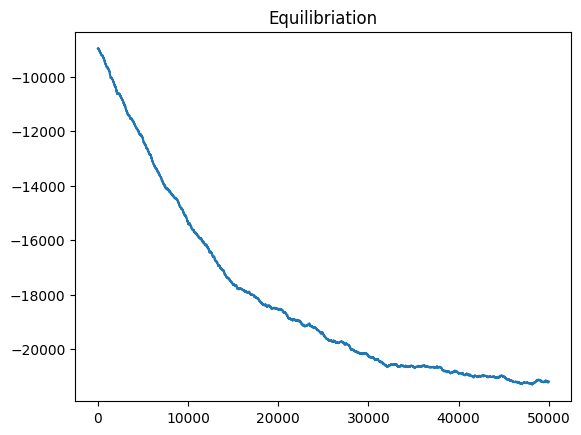

In [108]:

def convergence(steps:int, n,j,T,a_in, H = np.zeros((n,n), dtype = 'int'), fname = 'animation.mp4'):
    
    save_every = 1000
    numsteps = steps/save_every

    a = a_in.copy()

    energies = np.empty(steps)

    E = energy(a,j,H)


    data = []

    for i in range(steps):
        energies[i] = E


        if i % numsteps == 0:
            data.append(a)
        
        x = np.random.randint(0,n)
        y = np.random.randint(0,n)

        b = a.copy()
        b[x,y] *= -1

        dE = -(b[x,y] - a[x,y])*(j*(a[x,(y+1)%n] + a[(x+1)%n,y] + a[x,y-1] + a[x-1,y]) + H[x,y])

        '''if i % 100000 == 0:
            plt.imshow(a)
            plt.title(f"{i}th step")
            plt.show()
        '''
        
        if dE <= 0 or np.random.rand() <= np.exp(-dE * T**(-1)):
            E += dE
            a = b.copy()

    fig, ax = plt.subplots()
    im = ax.imshow(data[0])

    def update(frame):
        im.set_array(data[frame])
        return [im]

    ani = anim.FuncAnimation(fig, update, frames=len(data), interval=10, blit=True)

    ani.save(fname, fps=60)

    plt.show()
    return np.arange(steps), energies, a, a_in


n = 100
a_in = randominitial(n)
steps = 50000
T = 2.6
#H = sin_H(n, factor = 0.1)
#H = 10*circle_H(n,n/4)

H = np.zeros((n,n))

step, u, a, a_in = convergence(int(steps), n, 1, T, a_in, H = H, fname = f'equil.mp4')
plt.plot(step, u)
plt.title('Equilibriation')
plt.show()


a_in = a.copy()
H = 5*circle_H(n,n/4)

step, u, a, a_in = convergence(int(steps), n, 1, T, a_in, H = H, fname = f'animation_circle_T{T}.mp4')
plt.plot(step, u)
plt.title('Equilibriation')
plt.show()